## Twitter sentiment analysis

- This code performs sentiment analysis on airline tweets using a logistic regression model and visualizes various aspects of the analysis.

### Data Importing and Preprocessing:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Importing dataset

tweet_df = pd.read_csv('/Users/sakshimunde/Downloads/archive-4/Tweets.csv')
tweet_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
tweet_df.shape

(14640, 15)

In [7]:
tweet_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Data selection
- Only two columns, 'airline_sentiment' (the sentiment label) and 'text' (the tweet content), are selected from the dataset.

In [3]:
# Selecting only necessary columns for sentiment analysis

df = tweet_df[['airline_sentiment','text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Sentiment distribution visualisation:
- The code creates a histogram to visualise the distribution of airline sentiments.

In [4]:
# Count the occurences of each sentiment category:

sentiment_count = df['airline_sentiment'].count()
sentiment_count

14640

Text(0.5, 1.0, 'Distribution of airline sentiments')

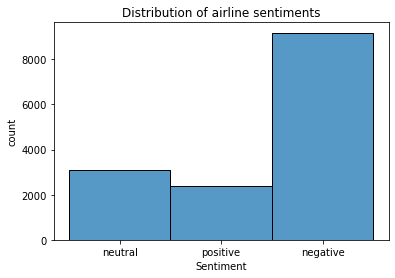

In [9]:

sns.histplot(df['airline_sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.title('Distribution of airline sentiments')

### Data label mapping:

- A mapping dictionary is defined to convert sentiment labels('positive', 'negative', 'neutral') to numerical values (1,0,2).

- Leading and trailing whitespaces in the "airline sentiment" column are removed.
- A new 'target' column is created to store the numerical sentiment values. 

In [10]:
# Create a mapping dictionary to convert snetiment labels to numerical values

target_map = {'positive':1, 'negative':0, 'neutral': 2}
target_map

{'positive': 1, 'negative': 0, 'neutral': 2}

In [11]:
# removing leading and trailing whitesapces from airline sentiment column

df['airline_sentiment'] = df['airline_sentiment'].str.strip()
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [12]:
# Apply the mapping to create a new target column with numerical sentiment values

df['target'] = df['airline_sentiment'].map(target_map)
df

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,0
14637,neutral,@AmericanAir Please bring American Airlines to...,2
14638,negative,"@AmericanAir you have my money, you change my ...",0


### Data Splitting:

- The dataset is split into training and testing sets using the train_test_split function.


In [13]:
# Split the dataset into training and test sets

df_train, df_test = train_test_split(df)
df_train.head()

,airline_sentiment,text,target
11986,negative,@AmericanAir can u help rebook passenger via T...,0
2185,negative,@united please fire the captain of flight 6232...,0
2682,neutral,@united How can I verify if wheelchair assista...,2
8540,negative,@JetBlue U say our safety is our highest prior...,0
7037,negative,This shits gotta stop RT @JetBlue: Our fleet's...,0


In [14]:
df_test.head()

,airline_sentiment,text,target
12029,negative,@AmericanAir 800 number will not even let you...,0
2740,neutral,"@united Yes, filled out the form last year. Do...",2
8329,negative,@JetBlue Alternatives? You have absolutely no...,0
13706,negative,@AmericanAir Your agent sent our family on 3 d...,0
7993,negative,".@JetBlue Ah grasshopper, your twitterz kung f...",0


## Text Vectorization (TF-IDF):

- Text data is vectorized using the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer. It generates TF-IDF features for both the training and testing sets.

In [16]:
# Vectorize text data using Tf-idf

vectorizer = TfidfVectorizer(max_features = 2000)
x_train = vectorizer.fit_transform(df_train['text'])
x_test = vectorizer.transform(df_test['text'])

y_train = df_train['target']
y_test = df_test['target']


### Model Training (Logistic Regression):

- A logistic regression model is trained using the training data.

In [17]:
model = LogisticRegression(max_iter= 500)
model.fit(x_train, y_train)

LogisticRegression(max_iter=500)

### Model Evaluation:

- The code evaluates the model using the training and testing datasets
- It calculates and prints train and test accuracies.
- It calculates ROC AUC scores for both the train and test sets.
- It creates normalized confusion matrices and visualizes them using heatmaps for both the train and test sets.

In [18]:
# Evaluate the model

train_accuracy = model.score(x_train, y_train)

train_accuracy

0.8540983606557377

In [19]:
test_accuracy = model.score(x_test, y_test)
test_accuracy

0.7972677595628416

In [21]:
# Predict the probabilities for ROC auc curve

pr_train = model.predict_proba(x_train)
pr_test = model.predict_proba(x_test)
pr_train


array([[0.87493618, 0.04088851, 0.08417531],
       [0.86303181, 0.04315663, 0.09381156],
       [0.56982775, 0.0257616 , 0.40441065],
       ...,
       [0.93089365, 0.01695713, 0.05214922],
       [0.82605011, 0.02755902, 0.14639087],
       [0.89271212, 0.06115731, 0.04613057]])

In [22]:
pr_test

array([[0.95772104, 0.02359194, 0.01868702],
       [0.81012239, 0.04011187, 0.14976573],
       [0.91329639, 0.0383422 , 0.04836141],
       ...,
       [0.9913893 , 0.00240357, 0.00620712],
       [0.94645372, 0.00999887, 0.04354742],
       [0.452414  , 0.34459285, 0.20299315]])

In [23]:
train_auc = roc_auc_score(y_train, pr_train, multi_class = 'ovo')
train_auc

0.9428179731097835

In [25]:
test_auc = roc_auc_score(y_test, pr_test, multi_class = 'ovo')
test_auc

0.8940782959697184

In [29]:
# Predict labels for confusion matrix
train_pred = model.predict(x_train)
train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
test_pred = model.predict(x_test)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
# Create a normalized confusion matrix for the training dataset
cm_train = confusion_matrix(y_train, train_pred, normalize = 'true')
cm_train

array([[0.9656123 , 0.00783517, 0.02655252],
       [0.19639842, 0.70568374, 0.09791784],
       [0.31458243, 0.04976201, 0.63565556]])

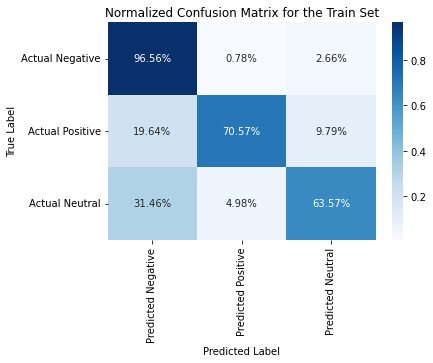

In [37]:
# Create a heatmep for the confusion matrix

sns.heatmap(cm_train, annot = True, fmt = '.2%', cmap = 'Blues',
           xticklabels = ['Predicted Negative','Predicted Positive','Predicted Neutral'],
           yticklabels = ['Actual Negative','Actual Positive','Actual Neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for the Train Set')
plt.show()

In [38]:
# Create a normalized confusion matrix for test dataset

cm_test = confusion_matrix(y_test, test_pred, normalize = 'true')
cm_test

array([[0.93569554, 0.01487314, 0.04943132],
       [0.22866894, 0.63481229, 0.13651877],
       [0.42385787, 0.05964467, 0.51649746]])

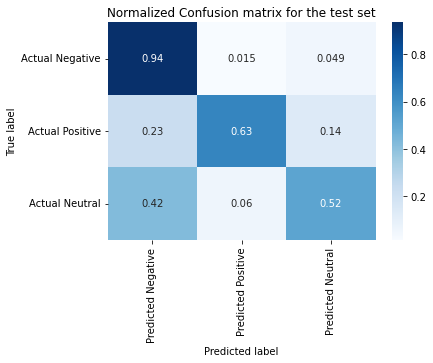

In [39]:
# Create a heatmap for the confusion matrix

sns.heatmap(cm_test, annot = True, cmap = 'Blues', 
           xticklabels = ['Predicted Negative', 'Predicted Positive','Predicted Neutral'],
           yticklabels = ['Actual Negative', 'Actual Positive','Actual Neutral'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion matrix for the test set")
plt.show()


### Binary Sentiment Classification:

- The code filters the dataset to focus on binary sentiment classification (positive vs. negative).
- The same TF-IDF vectorizer is used to vectorize text data for binary classification.
- Another logistic regression model is trained for binary classification.
### Model Evaluation (Binary Classification):

- The code evaluates the binary classification model:
- It calculates and prints train and test accuracies.
- It calculates ROC AUC scores for both the train and test sets.

In [42]:
# Filter the dataset to focus on binary sentiment classification (positive or negative)

binary_target_list = [target_map['positive'], target_map['negative']]
binary_target_list

[1, 0]

In [43]:
df_binary_train = df_train[df_train['target'].isin(binary_target_list)]
df_binary_train

,airline_sentiment,text,target
11986,negative,@AmericanAir can u help rebook passenger via T...,0
2185,negative,@united please fire the captain of flight 6232...,0
8540,negative,@JetBlue U say our safety is our highest prior...,0
7037,negative,This shits gotta stop RT @JetBlue: Our fleet's...,0
10900,negative,@USAirways I spoke with a customer service rep...,0
...,...,...,...
14622,negative,I just need a place to sleep when I land witho...,0
2587,negative,@united your system is down and after being on...,0
1042,negative,@united flight attendant doesn’t understand no...,0
1780,negative,@united I missed my connection already. Then I...,0


In [45]:
df_binary_test = df_test[df_test['target'].isin(binary_target_list)]
df_binary_test

,airline_sentiment,text,target
12029,negative,@AmericanAir 800 number will not even let you...,0
8329,negative,@JetBlue Alternatives? You have absolutely no...,0
13706,negative,@AmericanAir Your agent sent our family on 3 d...,0
7993,negative,".@JetBlue Ah grasshopper, your twitterz kung f...",0
13830,negative,@AmericanAir how nice it would be if you had h...,0
...,...,...,...
1995,negative,@united lost bag on next flight. Didn't have t...,0
13312,negative,@AmericanAir Please try it yourself - call 1-8...,0
13221,negative,@americanair why am I not being given a callba...,0
13758,negative,@AmericanAir what I am put off by is the fact ...,0


In [51]:
# Vectorize text data for the binary sentiment classification

x_train = vectorizer.fit_transform(df_binary_train['text'])
x_test = vectorizer.transform(df_binary_test['text'])

y_train = df_binary_train['target']
y_test = df_binary_test['target']

In [52]:
# Train a logistic regression model for binary classification

model = LogisticRegression(max_iter = 500)
model.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [53]:
binary_train_accuracy = model.score(x_train, y_train)
binary_train_accuracy

0.9279040258391972

In [55]:
binary_test_accuracy = model.score(x_test, y_test)
binary_test_accuracy

0.9136490250696379

In [56]:
# Predict the probabilities for ROC AUC Calculation (binary classification)
train_prob = model.predict_proba(x_train)[:,1]
test_prob = model.predict_proba(x_test)[:,1]


In [58]:
binary_train_accu = roc_auc_score(y_train, train_prob)
binary_train_accu

0.9843393333466154

In [59]:
binary_test_accu = roc_auc_score(y_test, test_prob)
binary_test_accu

0.9550942970865843

### Identifying Most Positive and Negative Words:

- The code identifies and prints the most positive and negative words based on feature weights and a specified threshold.
- Overall, this code provides a comprehensive analysis of airline tweets, including sentiment distribution, model training, evaluation, and visualization of feature weights and influential words for sentiment classification

In [61]:
# get the vocabulary index map

word_index_map = vectorizer.vocabulary_
word_index_map

{'americanair': 1459,
 'can': 2369,
 'help': 4915,
 'rebook': 7815,
 'passenger': 7161,
 'via': 10163,
 'twitter': 9734,
 'dm': 3524,
 'been': 1946,
 'on': 6923,
 'hold': 4991,
 'for': 4362,
 'hours': 5071,
 'thanks': 9356,
 'united': 9942,
 'please': 7367,
 'fire': 4195,
 'the': 9367,
 'captain': 2395,
 'of': 6881,
 'flight': 4245,
 '6232': 852,
 'today': 9524,
 'he': 4879,
 'single': 8621,
 'handedly': 4803,
 'ruined': 8215,
 'every': 3909,
 'passengers': 7163,
 'day': 3206,
 'by': 2304,
 'being': 1963,
 'piece': 7307,
 'shit': 8532,
 'unitedsucks': 9953,
 'jetblue': 5513,
 'say': 8317,
 'our': 7014,
 'safety': 8258,
 'is': 5423,
 'highest': 4955,
 'priority': 7536,
 'but': 2290,
 'that': 9364,
 'doesn': 3541,
 'extend': 4003,
 'property': 7602,
 'this': 9419,
 'totally': 9569,
 'nuts': 6830,
 'http': 5090,
 'co': 2713,
 'xzy7phkfgr': 10582,
 'shits': 8533,
 'gotta': 4674,
 'stop': 8989,
 'rt': 8202,
 'fleet': 4233,
 'fleek': 4232,
 'peq90pqmpp': 7228,
 'usairways': 10065,
 'spoke': 

In [62]:
# Define a threshold for identifying most positive and most negative words

threshold = 2

In [63]:
# Identify and print the most positive words

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word, weight)

thanks 8.37796560897526
jetblue 3.23043001512425
great 5.517832149449783
thank 8.045566183538911
awesome 4.001155066802173
southwestair 3.2434395628210058
good 2.892212636703057
virginamerica 3.2321941616946757
thx 2.7629598845043812
love 3.973971496463183
best 3.941099555325798
appreciate 2.938452375029504
amazing 4.093857331131379
worries 2.62004740802691
nice 2.0594185817719133
excellent 2.382375305025471
kudos 2.6609154885969475


In [64]:
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

hold -2.8910526827792062
hours -3.1084098678647893
is -2.0796502566632586
usairways -2.03550141511967
not -4.490833798923386
delayed -2.7716250806206126
what -2.626753637398854
no -4.112875609587649
cancelled -2.7188507496893286
worst -2.9029458343809575
hour -2.118724320478953
why -3.266571663939179
nothing -2.5147207343336992
